In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from scipy.cluster.hierarchy import dendrogram, linkage
from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv("./bank.csv", delimiter = ";")
eda_df = df.sample(n=2000, random_state=3001)
eda_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
3571,26,admin.,married,secondary,no,2469,no,no,cellular,16,jul,136,8,-1,0,unknown,no
3366,52,unknown,married,primary,no,247,no,no,cellular,29,jul,268,6,-1,0,unknown,no
2722,53,blue-collar,married,secondary,no,25,no,no,cellular,22,aug,528,2,-1,0,unknown,yes
1916,51,entrepreneur,married,tertiary,no,3921,yes,no,cellular,5,may,168,1,-1,0,unknown,no
2923,39,admin.,married,secondary,no,260,yes,no,cellular,17,apr,146,1,281,1,failure,no


# Columns
 Age:  Numeric, continious  

 Job:  Categorical, should be learnt how many unique job are there and using skleran.OneHotEncoder we should make this column numeric [1](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)

 Marital:  Categorical

 Education:  Categorical but also ordinal. Education can be unknown,secondary,primary, or tertiary. To make it more reasonable, we'll replace "unknown" with NaN and then fill them with mode. And then, using OrdinalEncoder we make this column ordinal. [2](https://
 scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html)
 
 Default:  Categorical, 
 
 Balance:  Numeric, continious. Since there are many rich people, we may need to normalize this feature.
 
 Housing:  Categorical
 
 Loan:  Categorical
 
 Contact:  Categorical, communication type
 
 Day:  Numeric, day of the month of last contact. We may drop tihs column, but first, we should see whether is there a correlation between day and y or not
 
 Month:  Categorical, we may drop this column.
 
 Duratin:  Numeric, duration of the last contact in seconds. We may want to drop this column too, there might be a data leakage, which makes our model working exceptionally. [3](https://www.ibm.com/think/topics/data-leakage-machine-learning)
 
 Campaign:  Numeric
 
 Pdays:  Numeric, days since the client was las contacted (1 means never contacted before). We may need to create a feature called isContacted to make#### 1 values more meaningful.
 
 Previous:  Numeric, number of previous contacts before this campaign.
 
 Poutcome:  Categorical, outcome of the previous marketing campaign. This can be unknown, failure, success. We may replace unknown with NaN an then fill this blanks with the mode.
 
 y:  Categorical, has the client subscribed to a term  deposit? The feature we're trying to predict.

In [3]:
print(df.info())
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB
None
(4521, 17)


### There are no missing values in our data.

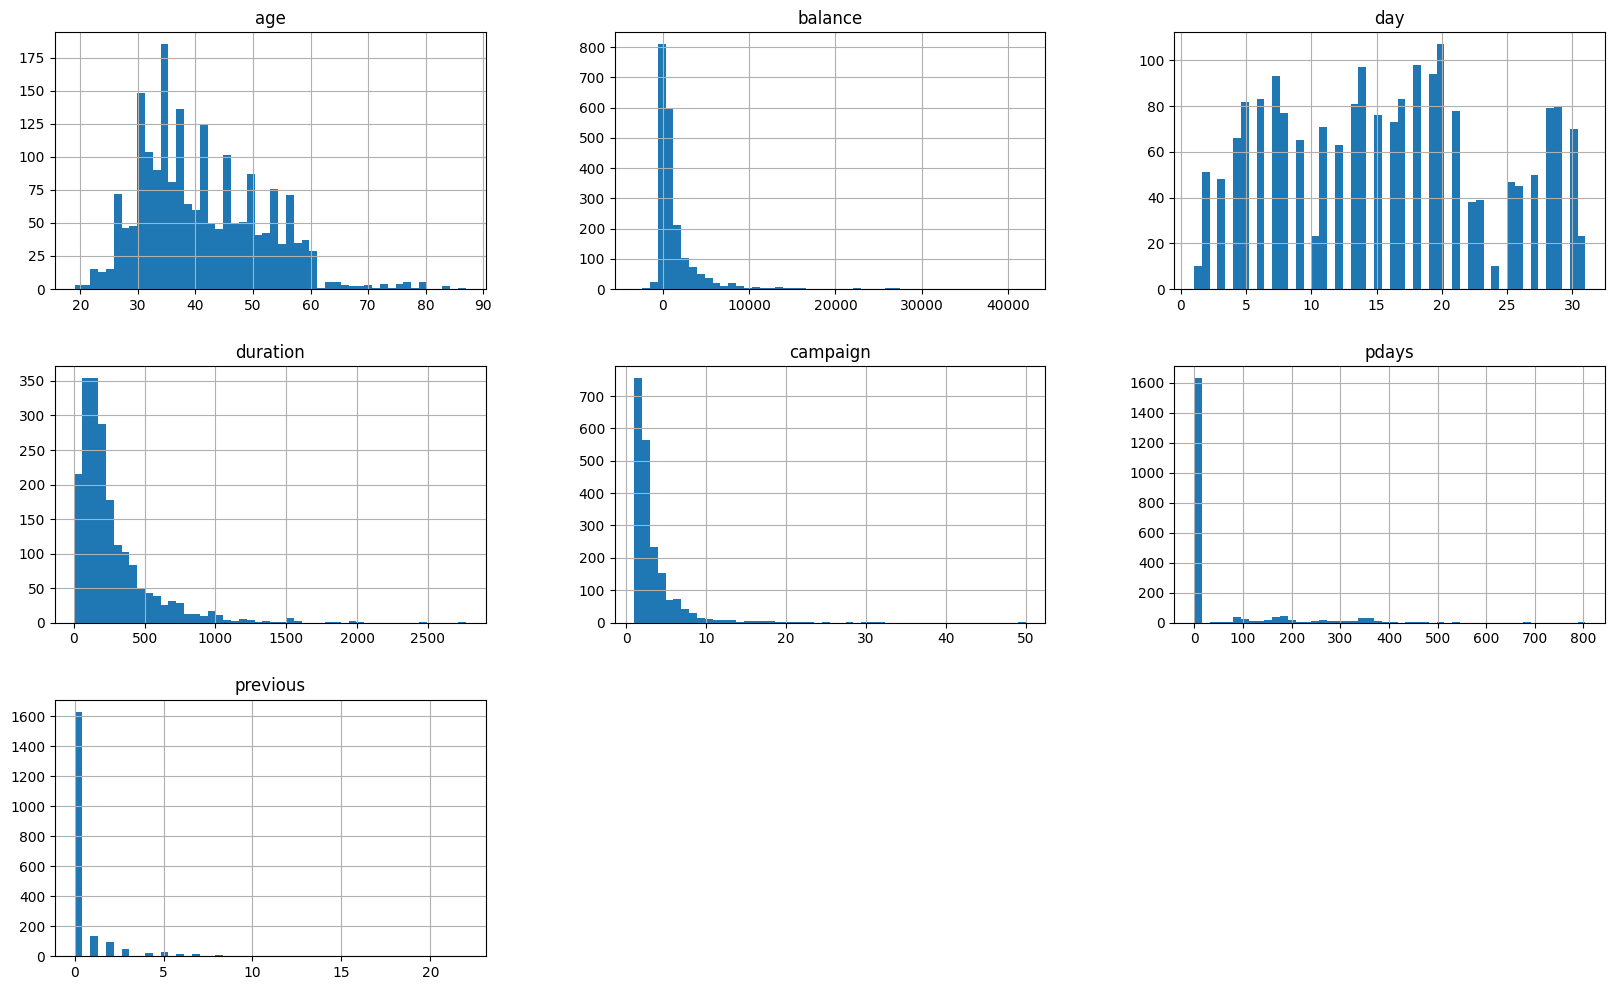

In [4]:
numerical_cols = eda_df.select_dtypes(include="number").columns
eda_df[numerical_cols].hist(bins=50, figsize=(20,12))
plt.show()


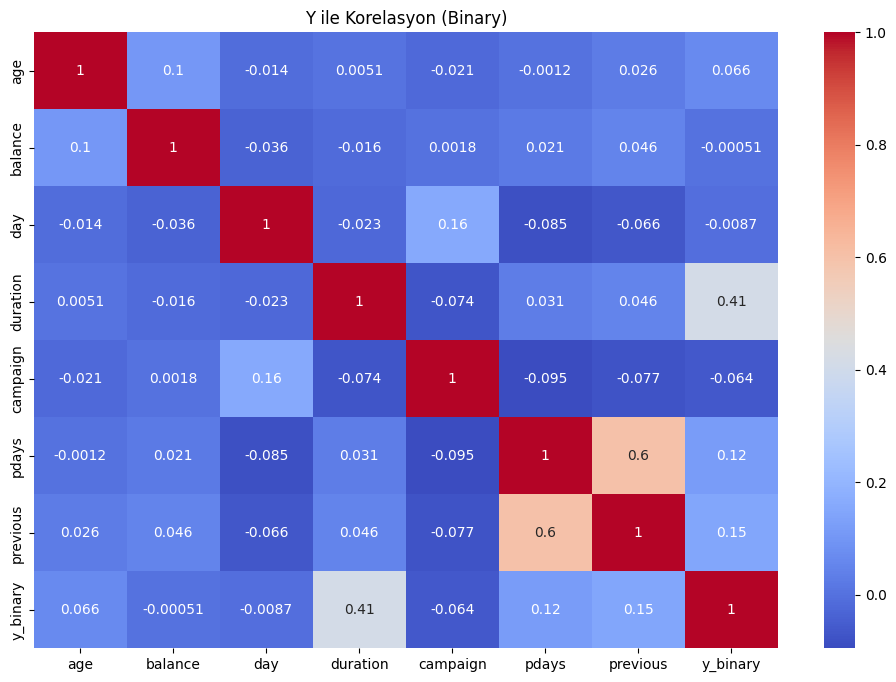

In [5]:
eda_df['y_binary'] = eda_df['y'].map({'yes': 1, 'no': 0})
numerics = eda_df.select_dtypes(include="number")

target_corr = numerics.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(target_corr, annot=True, cmap='coolwarm')
plt.title("Y ile Korelasyon (Binary)")
plt.show()


### As we said earlier, there is a exceptionally high correlation between duration and y. Possibly it is a data leakage, which we should avoid.

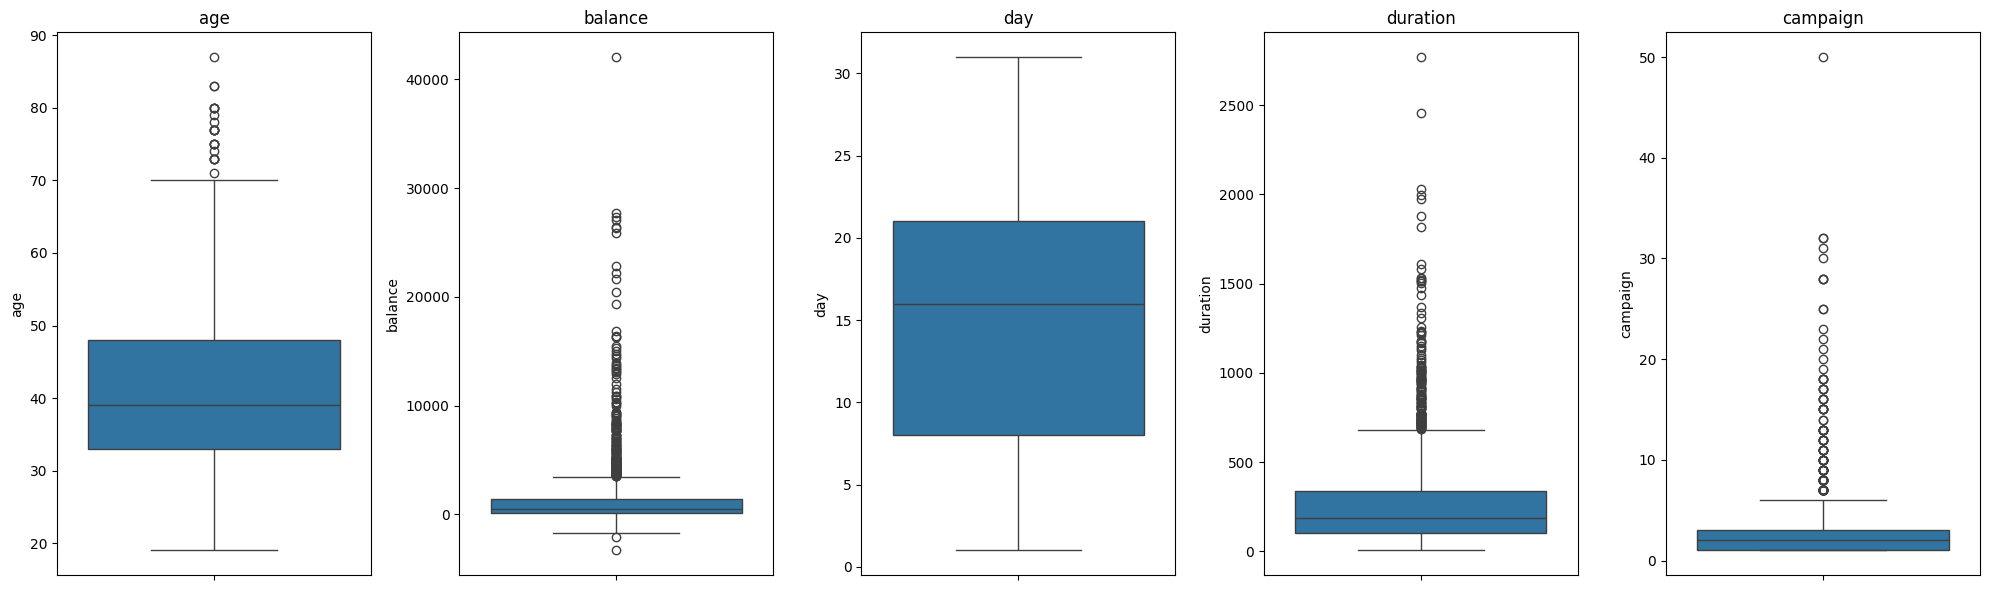

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20,6))

for i in range(5):
    sns.boxplot(data = eda_df[numerical_cols[i]], ax = axes[i])
    axes[i].set_title(numerical_cols[i])

plt.tight_layout()
plt.show()


1. In age and campaign columns, the medians are almost in the middle. There are outliers in these columns, but comparing to balance column, they are less than balance column.

2. Balance and duration columns have short whiskers and numerous outliers. That means these columns are imbalanced. So, we'll use StandardScaler [1]


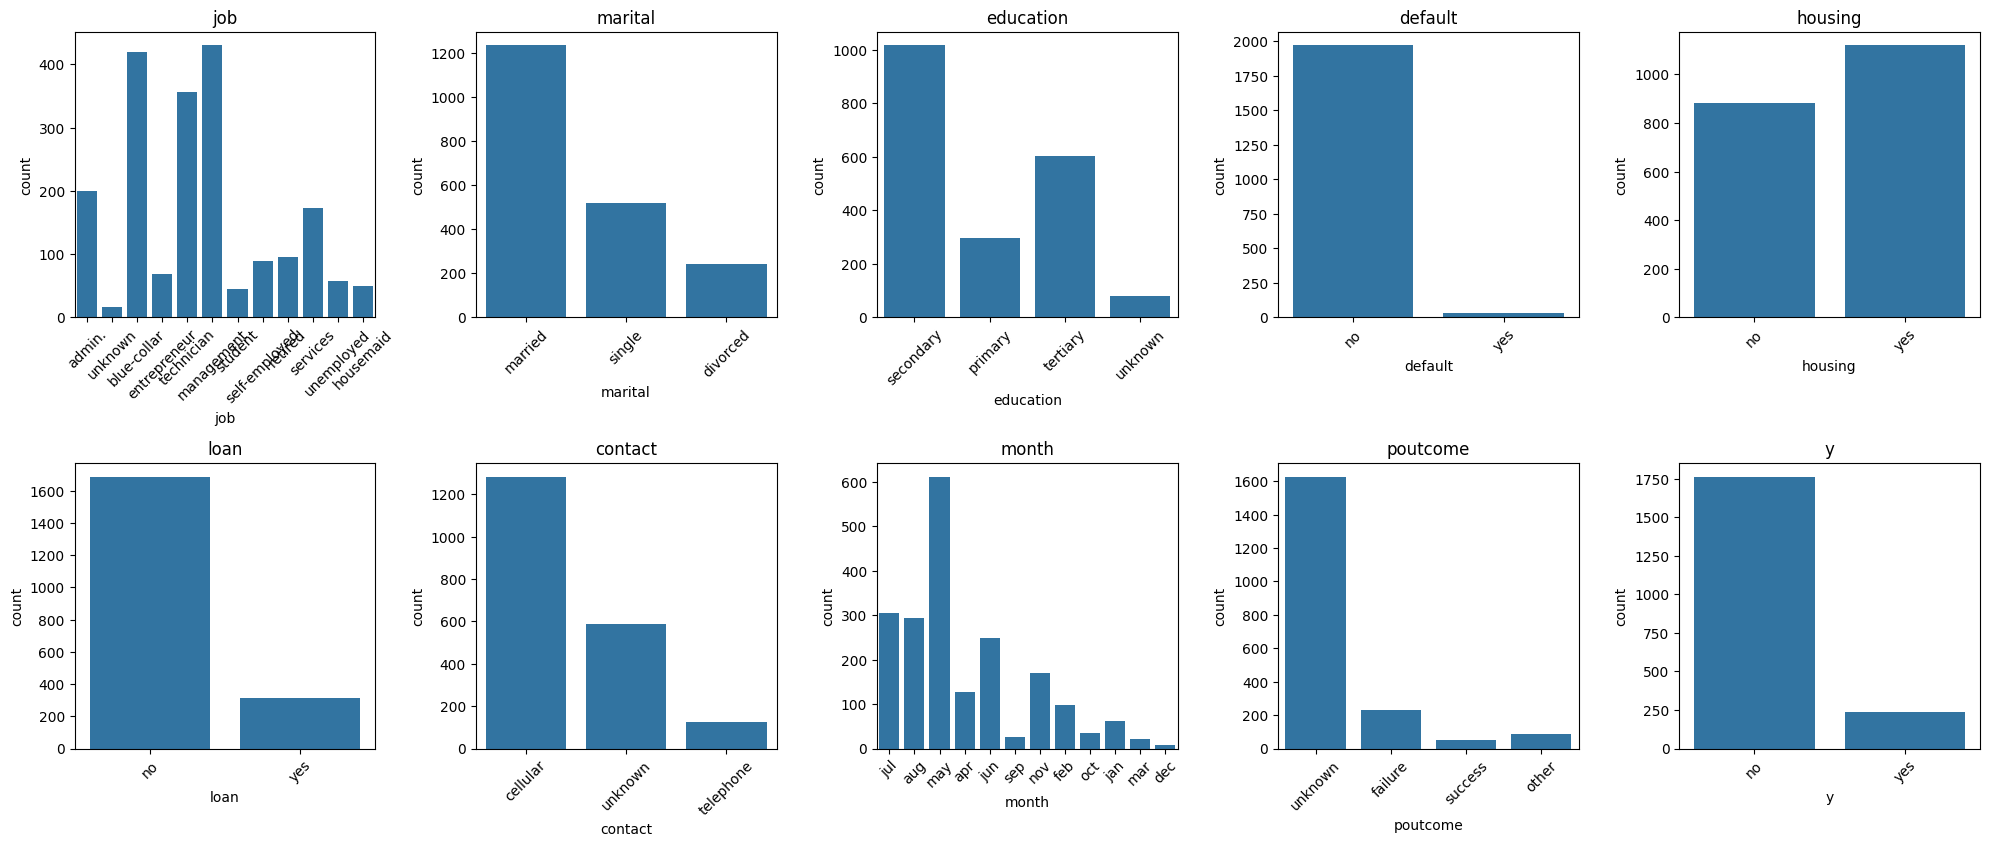

In [7]:
cat_cols = eda_df.select_dtypes("object").columns

fig, axes = plt.subplots(nrows=3, ncols=5, figsize = (20,12))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    sns.countplot(x=col, data=eda_df, ax=axes[i])
    axes[i].set_title(col)
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i+1, len(axes)):
    axes[j].set_visible(False)
    
plt.tight_layout()
plt.show()

## Inbalanced Features and Y
The target column (y) ise imbalanced. There are too few examples of the minority class (in this case "yes") fo a model to effectively learn the decision boundary.[1](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)

To fix it, we'll oversample the examples in the minority class. SMOTE (Synthetic Minority Oversampling TEchnique) is the approach we use.



Now let's see the correlation between categorical features and y using  Cramér's V method

Cramér’s V is an effect size measurement for the chi-square test of independence. It measures how strongly two categorical fields are associated.[2](https://www.ibm.com/docs/en/cognos-analytics/12.0.x?topic=terms-cramrs-v)

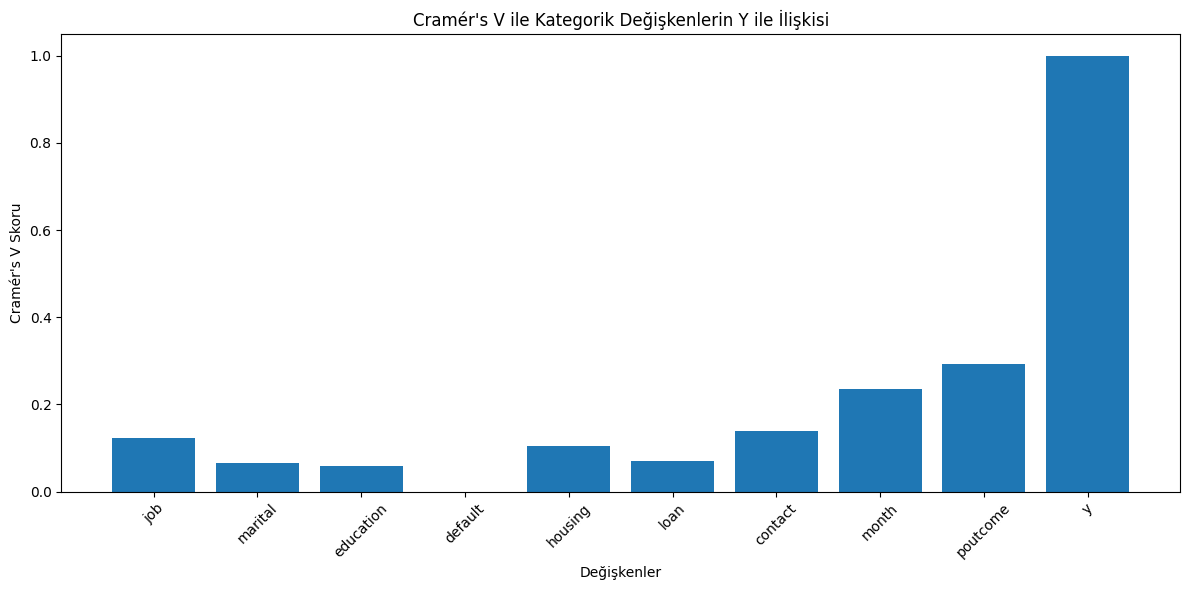

In [8]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k-1, r-1))

scores = []
for col in cat_cols:
    score = cramers_v(df[col], df['y'])
    scores.append(score)

plt.figure(figsize=(12,6))                 
plt.bar(cat_cols, scores)
plt.xticks(rotation=45)
plt.title("Cramér's V ile Kategorik Değişkenlerin Y ile İlişkisi")
plt.ylabel("Cramér's V Skoru")
plt.xlabel("Değişkenler")
plt.tight_layout()
plt.show()


### In real world, default rate is crucial. The default rate is the percentage of outstanding loans a lender writes off as unpaid after a prolonged period of missed payments. However, in this case, it doesn't have a significant role.

Recall that almost every data point in the default column was "no", which indicates a highly imbalanced distribution. As a result, this feature lacks variability and does not contribute meaningful information for modeling or prediction.

So, we'll drop that column.

### Let's make our categorical columns numeric

In [9]:
#--------------------Job---------------------------
most_freq_job = eda_df["job"].mode()[0]

eda_df["job"] = eda_df["job"].replace("unknown", most_freq_job)

eda_df["job"].unique()

#--------------------Education---------------------
education_order = ["primary", "secondary", "tertiary"]

eda_df["education"] = eda_df["education"].replace("unknown", np.nan)

most_frequent = eda_df["education"].mode()[0]

eda_df["education"] = eda_df["education"].replace(np.nan, most_frequent)

encoder = OrdinalEncoder(categories=[education_order])
eda_df["education"] = encoder.fit_transform(eda_df[["education"]])

In [10]:
#---------------------Contact-------------------
most_freq_job = eda_df["contact"].mode()[0]

eda_df["contact"] = eda_df["contact"].replace("unknown", most_freq_job)

eda_df["contact"].unique()

array(['cellular', 'telephone'], dtype=object)

In [11]:
#---------------------Default-------------------
eda_df.drop("default", axis=1, inplace=True)

#---------------------Duration------------------
eda_df.drop("duration", axis=1, inplace=True)

Since most of the poutcome column is "unknown" we may drop that column but as we saw earlier it has a role in output. We prefer to keep it, without changing it

In [12]:
eda_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 3571 to 937
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        2000 non-null   int64  
 1   job        2000 non-null   object 
 2   marital    2000 non-null   object 
 3   education  2000 non-null   float64
 4   balance    2000 non-null   int64  
 5   housing    2000 non-null   object 
 6   loan       2000 non-null   object 
 7   contact    2000 non-null   object 
 8   day        2000 non-null   int64  
 9   month      2000 non-null   object 
 10  campaign   2000 non-null   int64  
 11  pdays      2000 non-null   int64  
 12  previous   2000 non-null   int64  
 13  poutcome   2000 non-null   object 
 14  y          2000 non-null   object 
 15  y_binary   2000 non-null   int64  
dtypes: float64(1), int64(7), object(8)
memory usage: 265.6+ KB


Great. There is no missing value. Sometimes, somehow, it happens

In [13]:
cols = ["housing", "loan", "month", "poutcome", "contact", "marital", "job"]
eda_df = pd.get_dummies(eda_df, columns=cols, drop_first=True, dtype=int)
eda_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 3571 to 937
Data columns (total 38 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                2000 non-null   int64  
 1   education          2000 non-null   float64
 2   balance            2000 non-null   int64  
 3   day                2000 non-null   int64  
 4   campaign           2000 non-null   int64  
 5   pdays              2000 non-null   int64  
 6   previous           2000 non-null   int64  
 7   y                  2000 non-null   object 
 8   y_binary           2000 non-null   int64  
 9   housing_yes        2000 non-null   int64  
 10  loan_yes           2000 non-null   int64  
 11  month_aug          2000 non-null   int64  
 12  month_dec          2000 non-null   int64  
 13  month_feb          2000 non-null   int64  
 14  month_jan          2000 non-null   int64  
 15  month_jul          2000 non-null   int64  
 16  month_jun          2000 non

In [14]:
eda_df.dtypes

age                    int64
education            float64
balance                int64
day                    int64
campaign               int64
pdays                  int64
previous               int64
y                     object
y_binary               int64
housing_yes            int64
loan_yes               int64
month_aug              int64
month_dec              int64
month_feb              int64
month_jan              int64
month_jul              int64
month_jun              int64
month_mar              int64
month_may              int64
month_nov              int64
month_oct              int64
month_sep              int64
poutcome_other         int64
poutcome_success       int64
poutcome_unknown       int64
contact_telephone      int64
marital_married        int64
marital_single         int64
job_blue-collar        int64
job_entrepreneur       int64
job_housemaid          int64
job_management         int64
job_retired            int64
job_self-employed      int64
job_services  

Since our numeric columns have different ranges (for example, age and balance), we prefer to use StandardScaler to normalize the data and ensure that all features contribute equally to the model performance.

Also, we drop the y column since we already have y_binary

In [15]:
eda_df.drop("y", axis=1, inplace=True)

In [16]:
y, X = eda_df["y_binary"], eda_df.drop("y_binary", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=57)

Let's see our dendogram before scaling

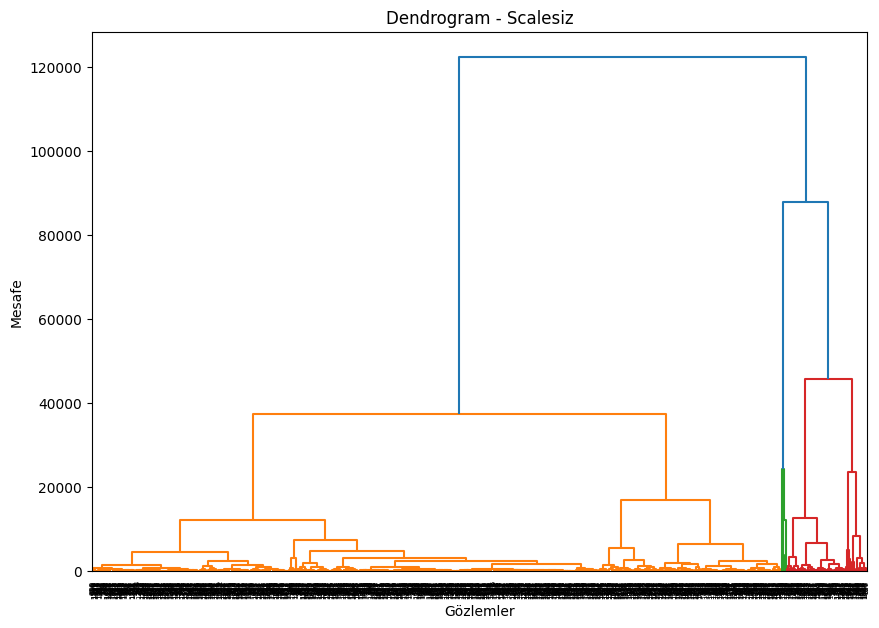

In [17]:
values_train = X_train.values

linked = linkage(values_train, method='ward')


plt.figure(figsize=(10, 7))
dendrogram(linked)
plt.title("Dendrogram - Scalesiz")
plt.xlabel("Gözlemler")
plt.ylabel("Mesafe")
plt.show()

In [18]:
scaler = StandardScaler()

num_cols = ["age", "balance", "day", "campaign", "pdays", "previous"]

X_train_scaled = X_train.copy()
X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])

In [19]:
eda_df.dtypes

age                    int64
education            float64
balance                int64
day                    int64
campaign               int64
pdays                  int64
previous               int64
y_binary               int64
housing_yes            int64
loan_yes               int64
month_aug              int64
month_dec              int64
month_feb              int64
month_jan              int64
month_jul              int64
month_jun              int64
month_mar              int64
month_may              int64
month_nov              int64
month_oct              int64
month_sep              int64
poutcome_other         int64
poutcome_success       int64
poutcome_unknown       int64
contact_telephone      int64
marital_married        int64
marital_single         int64
job_blue-collar        int64
job_entrepreneur       int64
job_housemaid          int64
job_management         int64
job_retired            int64
job_self-employed      int64
job_services           int64
job_student   

In [20]:
eda_df.shape


(2000, 37)

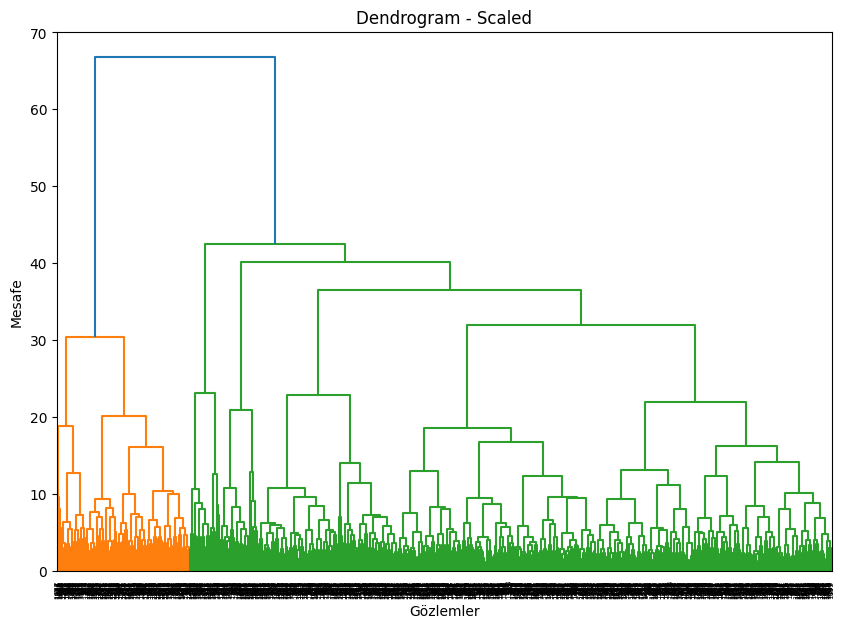

In [21]:
linked_scaled = linkage(X_train_scaled.values, method='ward')


plt.figure(figsize=(10, 7))
dendrogram(linked_scaled)
plt.title("Dendrogram - Scaled")
plt.xlabel("Gözlemler")
plt.ylabel("Mesafe")
plt.show()

In [22]:
eda_df["y_binary"].value_counts()

y_binary
0    1765
1     235
Name: count, dtype: int64

Since there is an 

In [23]:
smote = SMOTE(random_state=28)

X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

print(y_train.value_counts())
print(y_train_res.value_counts())

y_binary
0    1412
1     188
Name: count, dtype: int64
y_binary
0    1412
1    1412
Name: count, dtype: int64


In [24]:
model = LogisticRegression(random_state=57, max_iter=1000)

model.fit(X_train_res, y_train_res)

LogisticRegression(max_iter=1000, random_state=57)

In [25]:
X_test_scaled = X_test.copy()
num_cols = ["age", "balance", "day", "campaign", "pdays", "previous"]
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

In [26]:
y_pred = model.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.755

Confusion Matrix:
 [[289  64]
 [ 34  13]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.82      0.86       353
           1       0.17      0.28      0.21        47

    accuracy                           0.76       400
   macro avg       0.53      0.55      0.53       400
weighted avg       0.81      0.76      0.78       400



In [27]:
rf = RandomForestClassifier(random_state=57)
rf.fit(X_train_res, y_train_res)

y_pred = rf.predict(X_test_scaled)


print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.855
Confusion Matrix:
 [[334  19]
 [ 39   8]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.95      0.92       353
           1       0.30      0.17      0.22        47

    accuracy                           0.85       400
   macro avg       0.60      0.56      0.57       400
weighted avg       0.83      0.85      0.84       400



In [28]:
rf = RandomForestClassifier(random_state=57, class_weight="balanced")
rf.fit(X_train_res, y_train_res)

y_pred = rf.predict(X_test_scaled)


print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.855
Confusion Matrix:
 [[334  19]
 [ 39   8]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.95      0.92       353
           1       0.30      0.17      0.22        47

    accuracy                           0.85       400
   macro avg       0.60      0.56      0.57       400
weighted avg       0.83      0.85      0.84       400



In [29]:
rf = RandomForestClassifier(random_state=57, class_weight="balanced")
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test_scaled)


print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8825
Confusion Matrix:
 [[353   0]
 [ 47   0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.94       353
           1       0.00      0.00      0.00        47

    accuracy                           0.88       400
   macro avg       0.44      0.50      0.47       400
weighted avg       0.78      0.88      0.83       400



c:\Users\enesy\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\enesy\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\enesy\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [30]:
from imblearn.over_sampling import ADASYN

adasyn = ADASYN(random_state=57)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_scaled, y_train)

X_train_adasyn.shape, y_train_adasyn.shape

((2844, 36), (2844,))

In [31]:
rf = RandomForestClassifier(random_state=57)
rf.fit(X_train_adasyn, y_train_adasyn)


y_pred = rf.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8525
Confusion Matrix:
 [[333  20]
 [ 39   8]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.94      0.92       353
           1       0.29      0.17      0.21        47

    accuracy                           0.85       400
   macro avg       0.59      0.56      0.57       400
weighted avg       0.82      0.85      0.84       400



In [32]:
y_probs = rf.predict_proba(X_test_scaled)[:, 1]

In [33]:
from sklearn.metrics import precision_recall_fscore_support 

thresholds = np.arange(0.1, 0.9, 0.05)

for thresh in thresholds:
    y_pred_thresh = (y_probs >= thresh).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_thresh, average='binary')
    print(f"Threshold: {thresh:.2f} | Precision: {precision:.2f} | Recall: {recall:.2f} | F1: {f1:.2f}")

Threshold: 0.10 | Precision: 0.14 | Recall: 0.94 | F1: 0.24
Threshold: 0.15 | Precision: 0.16 | Recall: 0.79 | F1: 0.27
Threshold: 0.20 | Precision: 0.16 | Recall: 0.64 | F1: 0.26
Threshold: 0.25 | Precision: 0.17 | Recall: 0.53 | F1: 0.26
Threshold: 0.30 | Precision: 0.21 | Recall: 0.47 | F1: 0.29
Threshold: 0.35 | Precision: 0.27 | Recall: 0.43 | F1: 0.33
Threshold: 0.40 | Precision: 0.25 | Recall: 0.32 | F1: 0.28
Threshold: 0.45 | Precision: 0.25 | Recall: 0.23 | F1: 0.24
Threshold: 0.50 | Precision: 0.29 | Recall: 0.17 | F1: 0.21
Threshold: 0.55 | Precision: 0.29 | Recall: 0.13 | F1: 0.18
Threshold: 0.60 | Precision: 0.38 | Recall: 0.11 | F1: 0.17
Threshold: 0.65 | Precision: 0.30 | Recall: 0.06 | F1: 0.11
Threshold: 0.70 | Precision: 0.17 | Recall: 0.02 | F1: 0.04
Threshold: 0.75 | Precision: 0.25 | Recall: 0.02 | F1: 0.04
Threshold: 0.80 | Precision: 0.00 | Recall: 0.00 | F1: 0.00
Threshold: 0.85 | Precision: 0.00 | Recall: 0.00 | F1: 0.00
